# Integration of three modalities

In [1]:
import os
import sys
os.environ["OMP_NUM_THREADS"] = "11"
os.environ["OPENBLAS_NUM_THREADS"] = "8" # export OPENBLAS_NUM_THREADS=4 
os.environ["MKL_NUM_THREADS"] = "11" # export MKL_NUM_THREADS=6
os.environ["VECLIB_MAXIMUM_THREADS"] = "8" # export VECLIB_MAXIMUM_THREADS=4
os.environ["NUMEXPR_NUM_THREADS"] = "11" # export NUMEXPR_NUM_THREADS=6
os.environ["NUMBA_CACHE_DIR"]='/tmp/numba_cache'
import numpy as np
import pandas as pd
import scipy as sp
import scipy.sparse
import h5py

import tensorflow as tf
import matplotlib.pyplot as plt
import scanpy as sc

physical_devices = tf.config.list_physical_devices('GPU')
try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
    # Invalid device or cannot modify virtual devices once initialized.
    pass

2025-06-07 17:16:04.742987: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-07 17:16:04.763829: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-06-07 17:16:04.763847: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-06-07 17:16:04.764255: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-06-07 17:16:04.767130: I tensorflow/core/platform/cpu_feature_guar

## Load data

In [ ]:
with h5py.File('dogma_cite_asap.h5', 'r') as f:
    print(f.keys())
    peak_names = np.array(f['peak_names'], dtype='S32').astype(str)
    ADT_names = np.array(f['ADT_names'], dtype='S32').astype(str)
    gene_names = np.array(f['gene_names'], dtype='S32').astype(str)
    
    # Count matrices of three modalities: X for genes, Y for ADT, and Z for peaks.
    X = sp.sparse.csc_matrix(
        (np.array(f['RNA.data'], dtype=np.float32), 
         np.array(f['RNA.indices'], dtype=np.int32),
         np.array(f['RNA.indptr'], dtype=np.int32)
        ), 
        shape = np.array(f['RNA.shape'], dtype=np.int32)).tocsc().astype(np.float32)
    Y = np.array(f['ADT'], dtype=np.float32)
    Z = sp.sparse.csc_matrix(
        (np.array(f['peaks.data'], dtype=np.float32),
         np.array(f['peaks.indices'], dtype=np.int32),
         np.array(f['peaks.indptr'], dtype=np.int32)
        ), 
        shape = np.array(f['peaks.shape'], dtype=np.int32)).tocsc().astype(np.float32)
    cell_types = np.array(f['cell_types'], dtype='S32').astype(str)
    
    # The covariate matrix, the last column is the ids of datasets
    batches = np.array(f['batches'], dtype=np.float32)
    id_datasets = batches[:,-1]
    
    # The indices of features that are observed in each dataset.
    id_X_dogma = np.array(f['id_X_dogma'], dtype=np.int32)
    id_Y_dogma = np.array(f['id_Y_dogma'], dtype=np.int32)
    id_Z_dogma = np.array(f['id_Z_dogma'], dtype=np.int32)    
    id_X_cite = np.array(f['id_X_cite'], dtype=np.int32)
    id_Y_cite = np.array(f['id_Y_cite'], dtype=np.int32)
    id_Y_asap = np.array(f['id_Y_asap'], dtype=np.int32)
    id_Z_asap = np.array(f['id_Z_asap'], dtype=np.int32)
    
    # The sample size
    sample_sizes = np.array(f['sample_sizes'], dtype=np.int32)
    

# Count peaks in each chromosome (assuming they are ordered)
chunk_atac = np.array([
    np.sum(np.char.startswith(peak_names, 'chr%d-'%i)) for i in range(1,23)
    ], dtype=np.int32)
dim_input_arr = np.array([len(gene_names),len(ADT_names),len(peak_names)])
print(dim_input_arr)
    
# Preprocess the data
X = X.toarray()
X[batches[:,-1]!=2,:] = np.log1p(X[batches[:,-1]!=2,:]/np.sum(X[batches[:,-1]!=2,:], axis=1, keepdims=True)*1e4)
Y = np.log1p(Y/np.sum(Y, axis=1, keepdims=True)*1e4)
Z[Z>0.] = 1.
Z = Z.toarray()
data = np.c_[X, Y, Z]
conditions = batches[:,-1]

# The masks indicate missing pattern for three datasets.
# -1 means missing and 0 means observed.
masks = - np.ones((3, np.sum(dim_input_arr)), dtype=np.float32)
masks[0,id_X_dogma] = 0.
masks[0,id_Y_dogma+dim_input_arr[0]] = 0.
masks[0,id_Z_dogma+np.sum(dim_input_arr[:2])] = 0.
masks[1,id_X_cite] = 0.
masks[1,id_Y_cite+dim_input_arr[0]] = 0.
masks[2,id_Y_asap+dim_input_arr[0]] = 0.
masks[2,id_Z_asap+np.sum(dim_input_arr[:2])] = 0.

<KeysViewHDF5 ['ADT', 'ADT_names', 'RNA.data', 'RNA.indices', 'RNA.indptr', 'RNA.shape', 'batches', 'cell_ids', 'cell_types', 'gene_names', 'id_X_cite', 'id_X_dogma', 'id_Y_asap', 'id_Y_cite', 'id_Y_dogma', 'id_Z_asap', 'id_Z_dogma', 'peak_names', 'peaks.data', 'peaks.indices', 'peaks.indptr', 'peaks.shape', 'sample_sizes']>
[ 3660   227 38711]


## Set up config for model training

In [ ]:
import sys; sys.path.insert(0, '../../../../') # add parent folder path if not installed via PyPI
import scVAEIT
print(scVAEIT.__version__)

from scVAEIT.VAEIT import VAEIT
path_root = 'result/3/'

config = {
    # Dimension of input features for [RNA, ADT, peaks]
    'dim_input_arr': dim_input_arr,

    # Blocks for [RNA, ADT, peaks at chr1, ... peaks at chr22]
    'dim_block': np.append([len(gene_names),len(ADT_names)], chunk_atac), # input dimension of blocks
    'dist_block':['NB','NB'] + ['Bernoulli' for _ in chunk_atac], # distributions of blocks
    'dim_block_enc':np.array([256, 128] + [16 for _ in chunk_atac]), # dimension of first layer of the encoder
    'dim_block_dec':np.array([256, 128] + [16 for _ in chunk_atac]), # dimension of first layer of the decoder
    'block_names':np.array(['rna', 'adt'] + ['atac' for _ in range(len(chunk_atac))]), # names of blocks
    'uni_block_names':np.array(['rna','adt','atac']), # names for modalities
    'dim_block_embed':np.array([16, 8] + [1 for _ in range(len(chunk_atac))])*2, # mask embedding dimension

    # Internal network structure
    'dimensions':[256], # dimension of latent layers of encoder; the reversed is used for decoder
    'dim_latent':32, # the latent dimension between the encoder and decoder
    
    # Weights
    'beta_unobs':2./3., # weight for masked out observation; weight for observed values will be 1-beta_unobs.
    'beta_modal':np.array([0.14,0.85,0.01]), # weights for 3 modalities

    # Masking probability
    "p_feat" : 0.2, # probability of randomly masking out an entry
    "p_modal" : np.ones(3)/3, # probability of masking out the 3 modalities
    
    'gamma':lambda epoch: 2 * 0.8 ** (epoch / 50) # MMD loss to correct strong batch effects of multiple datasets
}


batches_cate = batches
batches_cont = None


model = VAEIT(config, data, 
                masks, id_datasets, 
                batches_cate, batches_cont, conditions)

1.1.0


2025-06-07 17:16:38.694681: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-06-07 17:16:38.694820: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-06-07 17:16:38.694875: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

Missingness (overall): 0.4513
Missingness (per row): mean=0.4513, min=0.0990, max=0.9389
Missingness (per column): mean=0.4513, min=0.0000, max=0.6667
namespace(beta_kl=2.0, beta_unobs=0.6666666666666666, beta_reverse=0.0, beta_modal=array([0.14, 0.85, 0.01]), p_modal=array([0.33333333, 0.33333333, 0.33333333]), p_feat=0.2, uni_block_names=array(['rna', 'adt', 'atac'], dtype='<U4'), block_names=array(['rna', 'adt', 'atac', 'atac', 'atac', 'atac', 'atac', 'atac',
       'atac', 'atac', 'atac', 'atac', 'atac', 'atac', 'atac', 'atac',
       'atac', 'atac', 'atac', 'atac', 'atac', 'atac', 'atac', 'atac'],
      dtype='<U4'), dist_block=array(['NB', 'NB', 'Bernoulli', 'Bernoulli', 'Bernoulli', 'Bernoulli',
       'Bernoulli', 'Bernoulli', 'Bernoulli', 'Bernoulli', 'Bernoulli',
       'Bernoulli', 'Bernoulli', 'Bernoulli', 'Bernoulli', 'Bernoulli',
       'Bernoulli', 'Bernoulli', 'Bernoulli', 'Bernoulli', 'Bernoulli',
       'Bernoulli', 'Bernoulli', 'Bernoulli'], dtype='<U9'), dim_block=a

In [4]:
hist = model.train(
        num_epoch=300, batch_size=512, save_every_epoch=50,
        verbose=True, checkpoint_dir=path_root+'checkpoint/')

Deleting old log directory at example/result/3/checkpoint/
Train - Start of epoch 1


2025-06-07 13:08:10.977797: I external/local_xla/xla/service/service.cc:168] XLA service 0x5f77aef63740 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-06-07 13:08:10.977859: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4090, Compute Capability 8.9
2025-06-07 13:08:14.032298: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-06-07 13:08:15.220056: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907
I0000 00:00:1749301696.196012 4027914 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


60/60 [==============================] - 45s 744ms/step - Reconstructed Loss: 484.0278
Epoch 1, Time elapsed: 0.74 minutes
          total, obs_rna, obs_adt, obs_atac, unobs_rna, unobs_adt, unobs_atac,      kl,     mmd
train :  504.60,   96.66,  121.16,   48.24,   81.04,   96.14,   40.28,   18.59,    2.47
Train - Start of epoch 2
60/60 [==============================] - 10s 170ms/step - Reconstructed Loss: 380.8526
Epoch 2, Time elapsed: 0.92 minutes
          total, obs_rna, obs_adt, obs_atac, unobs_rna, unobs_adt, unobs_atac,      kl,     mmd
train :  384.56,   65.47,  106.73,   33.29,   54.06,   85.52,   31.82,    4.82,    2.85
Train - Start of epoch 3
60/60 [==============================] - 10s 169ms/step - Reconstructed Loss: 365.4178
Epoch 3, Time elapsed: 1.09 minutes
          total, obs_rna, obs_adt, obs_atac, unobs_rna, unobs_adt, unobs_atac,      kl,     mmd
train :  364.38,   64.94,  104.85,   27.54,   52.45,   84.92,   23.86,    3.12,    2.70
Train - Start of epoch 4
60/6

We can visualize the training loss. It fluctuates since we argument the data with random masking, which also provides regularization against overfitting.
One may continue training until the loss gets stabilized.

Text(0, 0.5, 'Trianing loss')

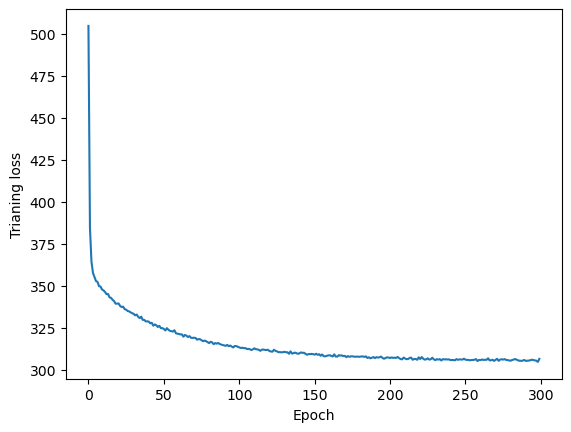

In [5]:
plt.plot(hist['train']['total'])
plt.xlabel('Epoch')
plt.ylabel('Trianing loss')

### Continue training saved models

We can continue training by specifying `init_epoch` and `num_epoch` arguments. Note that the value of `init_epoch` should depend on the number of epoch the latest checkpoint correponds to. 
As an example, above we have trained and saved the model at 300th epoch. So we can set `init_epoch=301` and increase the value of `num_epoch`.

In [6]:
hist = model.train(
        init_epoch=301, num_epoch=500, batch_size=512, save_every_epoch=50,
        verbose=True, checkpoint_dir=path_root+'checkpoint/')

Restored from example/result/3/checkpoint/ckpt-6
Train - Start of epoch 301


2025-06-07 14:05:07.149298: I external/local_xla/xla/service/service.cc:168] XLA service 0x5cc9dbc8a8e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-06-07 14:05:07.149311: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4090, Compute Capability 8.9
2025-06-07 14:05:07.151686: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-06-07 14:05:07.199237: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907
I0000 00:00:1749305107.252957 4044460 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


60/60 [==============================] - 35s 586ms/step - Reconstructed Loss: 307.7986
Epoch 301, Time elapsed: 0.59 minutes
          total, obs_rna, obs_adt, obs_atac, unobs_rna, unobs_adt, unobs_atac,      kl,     mmd
train :  306.01,   56.17,   88.75,   23.75,   45.92,   70.86,   19.16,    1.37,    0.02
Train - Start of epoch 302
60/60 [==============================] - 10s 170ms/step - Reconstructed Loss: 305.0807
Epoch 302, Time elapsed: 0.76 minutes
          total, obs_rna, obs_adt, obs_atac, unobs_rna, unobs_adt, unobs_atac,      kl,     mmd
train :  304.84,   56.16,   88.75,   23.72,   44.60,   70.78,   19.42,    1.38,    0.02
Train - Start of epoch 303
60/60 [==============================] - 10s 165ms/step - Reconstructed Loss: 306.3941
Epoch 303, Time elapsed: 0.92 minutes
          total, obs_rna, obs_adt, obs_atac, unobs_rna, unobs_adt, unobs_atac,      kl,     mmd
train :  305.94,   56.19,   88.75,   23.73,   45.14,   71.33,   19.39,    1.39,    0.02
Train - Start of ep

### Loading checkpoints

For later usage, we can load the trained model through the `load_model` method without the need to retrain:

```python
model.load_model(path_root+'checkpoint/')
```

## Obtain integrative latent representations

In [ ]:
model.update_z()

In [ ]:
# the latent variables are stored in model.adata
map_dict = {0:'Control',1:'Stimulation'}
condition = np.array([map_dict[i] for i in batches[:,0]])
map_dict = {0:'DOGMA-seq',1:'CITE-seq',2:'ASAP-seq'}
dataset = np.array([map_dict[i] for i in batches[:,-1]])

model.adata.obs['Condition'] = condition
model.adata.obs['Condition'] = model.adata.obs['Condition'].astype("category")
model.adata.obs['Dataset'] = dataset
model.adata.obs['Dataset'] = model.adata.obs['Dataset'].astype("category")
model.adata.obs['Cell Types'] = cell_types
model.adata

AnnData object with n_obs × n_vars = 30987 × 32
    obs: 'Condition', 'Dataset', 'Cell Types'
    uns: 'neighbors'
    obsp: 'distances', 'connectivities'

Calculate UMAP ...


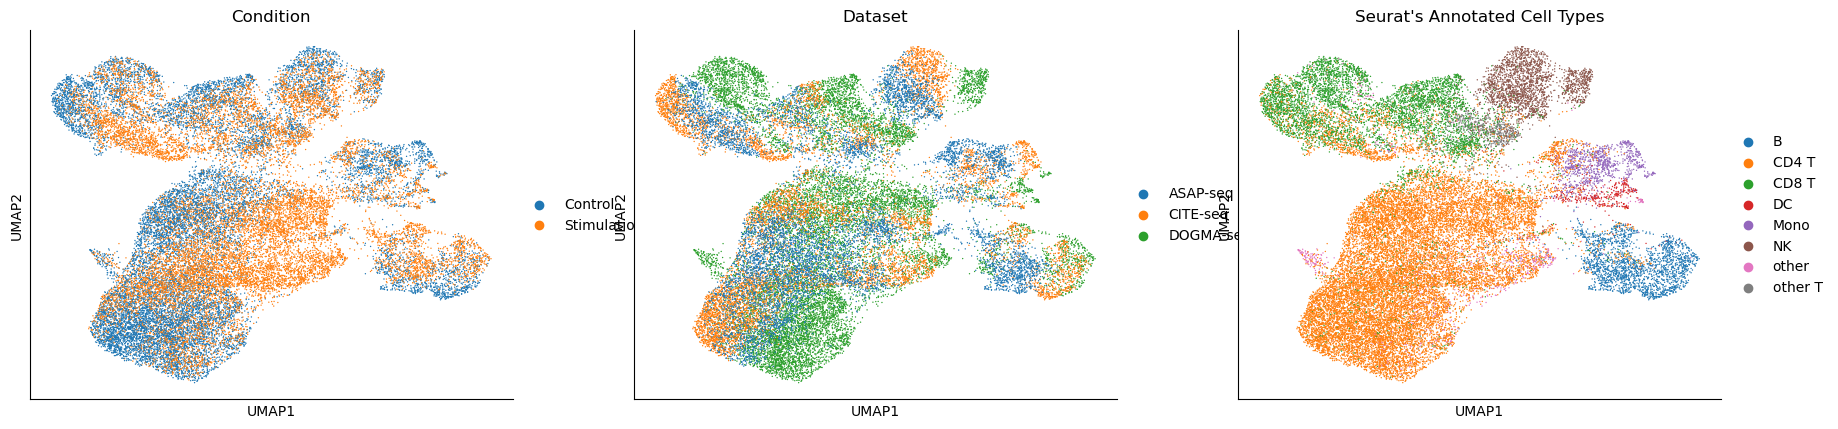

In [ ]:
axes = model.visualize_latent(method = "UMAP", color = [
    'Condition','Dataset','Cell Types'], show=False)
axes[2].set_title("Seurat's Annotated Cell Types")

# Hide the right and top spines
axes[0].spines.right.set_visible(False)
axes[0].spines.top.set_visible(False)

# Only show ticks on the left and bottom spines
axes[0].yaxis.set_ticks_position('left')
axes[0].xaxis.set_ticks_position('bottom')

axes[1].spines.right.set_visible(False)
axes[1].spines.top.set_visible(False)
axes[1].yaxis.set_ticks_position('left')
# axes[0].xaxis.set_ticks_position('bottom')

axes[2].spines.right.set_visible(False)
axes[2].spines.top.set_visible(False)
axes[2].yaxis.set_ticks_position('left')
plt.show()

## Visualize the denoised and imputed expressions

In [ ]:
denoised_data = model.get_denoised_data(
    batch_size_inference=128, L=50)

adata = sc.AnnData(
    X=pd.DataFrame(data[:,:model.vae.config.dim_input_arr[0]], columns=gene_names))

adata.uns = model.adata.uns
adata.obsm = model.adata.obsm
adata.obs = model.adata.obs

adata_hat = sc.AnnData(
    X=pd.DataFrame(denoised_data[:,:model.vae.config.dim_input_arr[0]], columns=gene_names))

adata_hat.uns = model.adata.uns
adata_hat.obsm = model.adata.obsm
adata_hat.obs = model.adata.obs

/home/jinhongd/anaconda3/envs/tf/lib/python3.9/site-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/jinhongd/anaconda3/envs/tf/lib/python3.9/site-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


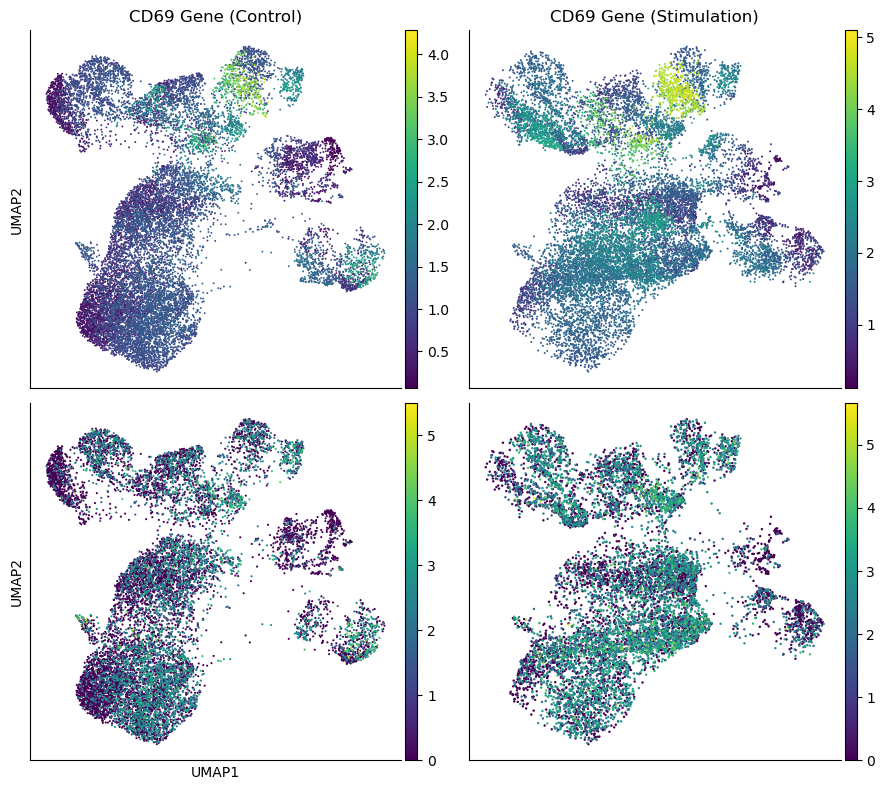

In [ ]:
fig, axes = plt.subplots(2,2,figsize=(9,8))
sc.pl.umap(adata_hat[adata.obs['Condition']=='Control'], 
           color='CD69', ax=axes[0,0], show=False)
sc.pl.umap(adata_hat[adata.obs['Condition']!='Control'], 
           color='CD69', ax=axes[0,1], show=False)
sc.pl.umap(adata[(adata.obs['Dataset']!='ASAP-seq')&
    (adata.obs['Condition']=='Control')], 
           color='CD69', ax=axes[1,0], show=False)
sc.pl.umap(adata[(adata.obs['Dataset']!='ASAP-seq')&
    (adata.obs['Condition']!='Control')], 
           color='CD69', ax=axes[1,1], show=False)

for i in range(2):
    for j in range(2):
        
        # Hide the right and top spines
        axes[i,j].spines.right.set_visible(False)
        axes[i,j].spines.top.set_visible(False)

        # Only show ticks on the left and bottom spines
        axes[i,j].yaxis.set_ticks_position('left')
        axes[i,j].xaxis.set_ticks_position('bottom')
        
        axes[i,j].set_xlabel('')
        axes[i,j].set_ylabel('')
        axes[i,j].set_title('')
axes[1,0].set_xlabel('UMAP1')
axes[0,0].set_ylabel('UMAP2')
axes[1,0].set_ylabel('UMAP2')

axes[0,0].set_title('CD69 Gene (Control)')
axes[0,1].set_title('CD69 Gene (Stimulation)')

plt.tight_layout()

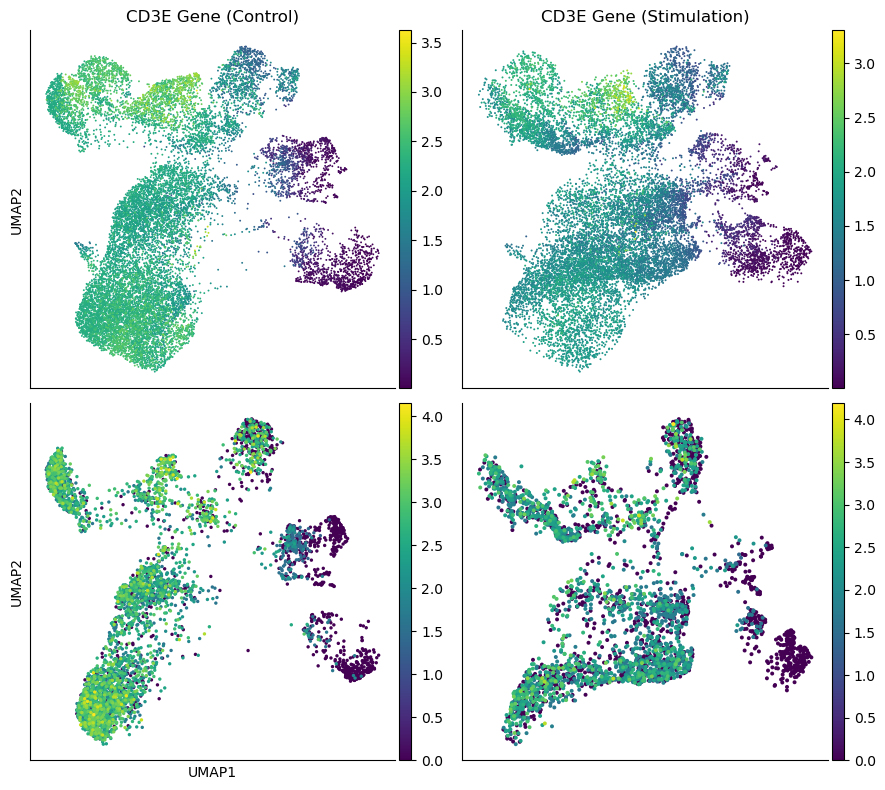

In [ ]:
fig, axes = plt.subplots(2,2,figsize=(9,8))
sc.pl.umap(adata_hat[adata.obs['Condition']=='Control'], 
           color='CD3E', ax=axes[0,0], show=False)
sc.pl.umap(adata_hat[adata.obs['Condition']!='Control'], 
           color='CD3E', ax=axes[0,1], show=False)
sc.pl.umap(adata[(adata.obs['Dataset']=='CITE-seq')&
    (adata.obs['Condition']=='Control')], 
           color='CD3E', ax=axes[1,0], show=False)
sc.pl.umap(adata[(adata.obs['Dataset']=='CITE-seq')&
    (adata.obs['Condition']!='Control')], 
           color='CD3E', ax=axes[1,1], show=False)

for i in range(2):
    for j in range(2):
        
        # Hide the right and top spines
        axes[i,j].spines.right.set_visible(False)
        axes[i,j].spines.top.set_visible(False)

        # Only show ticks on the left and bottom spines
        axes[i,j].yaxis.set_ticks_position('left')
        axes[i,j].xaxis.set_ticks_position('bottom')
        
        axes[i,j].set_xlabel('')
        axes[i,j].set_ylabel('')
        axes[i,j].set_title('')
axes[1,0].set_xlabel('UMAP1')
axes[0,0].set_ylabel('UMAP2')
axes[1,0].set_ylabel('UMAP2')

axes[0,0].set_title('CD3E Gene (Control)')
axes[0,1].set_title('CD3E Gene (Stimulation)')

plt.tight_layout()
plt.show()